In [1]:
# !pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate
     



In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os


# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

Loading the Models

In [3]:

# for autocompression.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# CLIP model.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for predicting the noise.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# running in gpu if its there
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);
     

In [43]:
# prompt = ["A watercolor painting of a ghost"]
# text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
# print(text_input)
# tokenizer.special_tokens_map
# tokenizer.decode(49407)

In [44]:
# prompt = ["A watercolor painting of a ghost"]
# text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
# with torch.no_grad():
#     text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
# text_embeddings.shape

In [5]:
# scheduler

AutoEncoder

In [8]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    # everything is the result of using ToTensor and we are just  modifying its output
    with torch.no_grad():
        latent = vae.encode(
            tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device) * 2 - 1
        )  # Note scaling [-1,1] from [0,1]
    return 0.18215 * latent.latent_dist.sample()  # Implementation as per the official research paper


def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents  # back to original latents
    with torch.no_grad():
        image = vae.decode(latents).sample  # scaled pixel is in the range [-1,1]
    
    image = (image / 2 + 0.5).clamp(0, 1)  # reverse operation of () * 2 -1 in the encode section. from [-1,1] to [0,1]
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")  # [0, 255] from [0.1]
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

    # encoder = [0,255] --->ToTensor-->[0,1] ---->[-1,1]
    # decoder = [-1.1] ----> [0,1] ----> [0, 255]

In [20]:
# Download a demo Image
!curl --output car.jpg 'https://d2hucwwplm5rxi.cloudfront.net/wp-content/uploads/2021/11/05091906/Lamborghini-facts-cover-051120210230-420x230.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  135k  100  135k    0     0   246k      0 --:--:-- --:--:-- --:--:--  245k


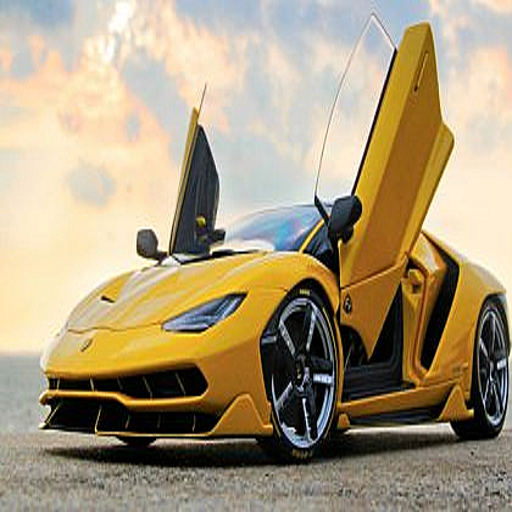

In [21]:

# Load the image with PIL
input_image = Image.open('car.jpg').resize((512, 512))
input_image

In [11]:
type(input_image)

PIL.Image.Image

In [22]:

# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

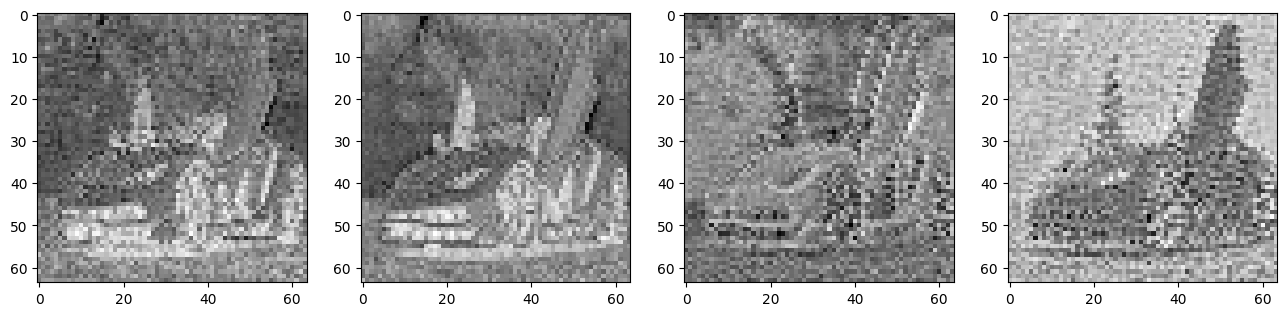

In [23]:
# visualizing latent representation in each of the 4 channels:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')


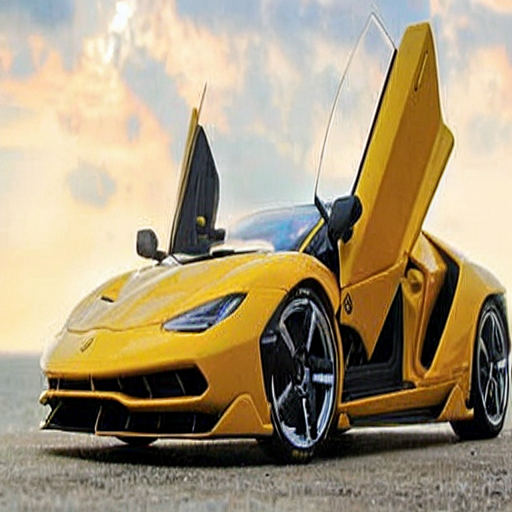

In [24]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

The Noise Scheduler

In [34]:

# Setting the number of sampling steps:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)
set_timesteps(scheduler, 15)
     

In [19]:
print(scheduler.timesteps)

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000])


In [17]:

# Look at the equivalent noise levels:
print(scheduler.sigmas)          # that means we are adding small noise in the beginning and increasing it gradually during training

tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])


During Sampling/inference, we'd need to start at higher noise and gradually denoise 

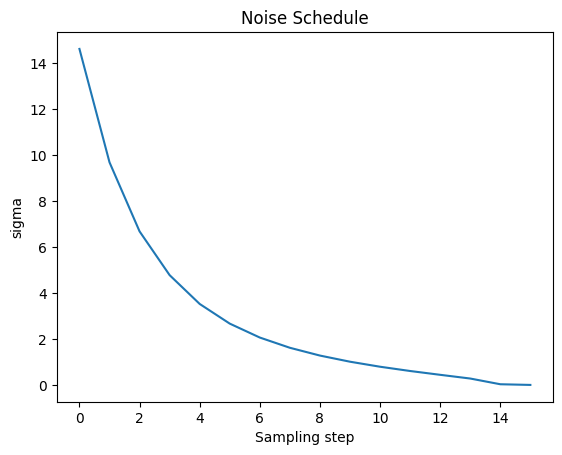

In [18]:
# Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

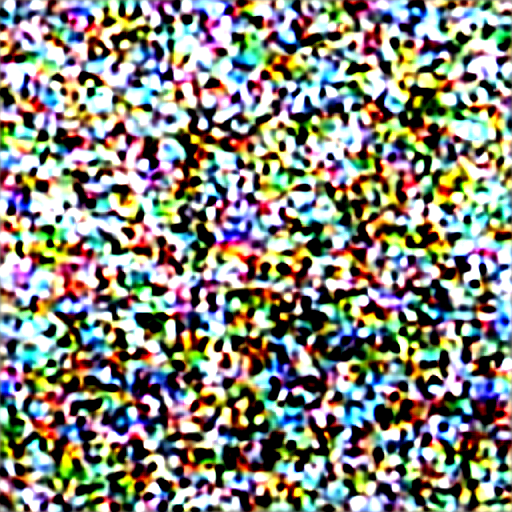

In [33]:
noise = torch.randn_like(encoded) # Random noise
sampling_step = 10 # Equivalent to step 10 out of 15 in the schedule above
# encoded_and_noised = scheduler.add_noise(encoded, noise, timestep) # Diffusers 0.3 and below
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
latents_to_pil(encoded_and_noised.float())[0] # Display

What we have done here is that, we have added noise of same shape as that of the latent representation i.e encoded and the noise is scaled by a sigma value (which is at sampling step = 10). The noise is added using scheduler.add_noise method that returns noisy_samples as described below:


The mathematical expression is: 

noisy_samples = original_samples(encoded) + noise * sigma

loop starting from sampling_step = 10

In [31]:
prompt = 'Oil painting of a '
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(32)
batch_size = 1

# Make a folder to store results

!mkdir -p /notebooks/cars

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Preparing Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

set_timesteps(scheduler,num_inference_steps)

# Preparing latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# diffuser Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # for classifier free guidance
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)  #tilting more towards prompt

    # Getting the denoised latents

    latents_x0 = latents - sigma * noise_pred 

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

    # To PIL Images
    im_t0 = latents_to_pil(latents_x0)[0]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'/notebooks/cars/{i:04}.jpeg')

/tmp/ipykernel_186/4280313967.py:35: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

In [32]:

# Make and show the progress video (change width to 1024 for full res)
!ffmpeg -v 1 -y -f image2 -framerate 12 -i /notebooks/cars/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p car.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()